In [1]:
import numpy as np
import scipy as sp
import glob,os
%pylab inline --no-import-all
plt.rc('font', family='serif', serif='Times',size=15)
plt.rc('text', usetex=True)
plt.rc('xtick', labelsize=20)
plt.rc('xtick.major', size=10)
plt.rc('ytick.major', size=10)
plt.rc('ytick', labelsize=20)
plt.rc('axes', labelsize=20)
plt.rc('figure',titlesize=25)
plt.rcParams['image.origin'] = 'lower'
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['axes.linewidth'] = 2.
from astropy.io import fits
import pandas as pd
import logging as log
from crispy.tools.initLogger import getLogger
log = getLogger('main')
from crispy.tools.image import Image
os.chdir('/Users/mrizzo/IFS/crispy/crispy/WFIRST/')
from params import Params
par = Params()
par.hdr

Populating the interactive namespace from numpy and matplotlib


SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                    8 / array data type                                
NAXIS   =                    0 / number of array dimensions                     
EXTEND  =                    T                                                  
COMMENT                                                                         
COMMENT ************************************************************            
COMMENT ********************** General parameters ******************            
COMMENT ************************************************************            
COMMENT                                                                         
NLENS   =                  108 / # lenslets across array                        
PITCH   =             0.000174 / Lenslet pitch (meters)                         
INTERLAC=                  2.0 / Interlacing                                    
PHILENS =    26.565051177077

In [2]:
lensX=10
lensY=10

from crispy.tools.locate_psflets import PSFLets
from crispy.tools.reduction import get_cutout
polychromeR = fits.open(par.wavecalDir + 'polychromeR%d.fits.gz' % (par.R))
psflets = polychromeR[0].data
psftool = PSFLets()
lamlist = np.loadtxt(par.wavecalDir + "lamsol.dat")[:, 0]
allcoef = np.loadtxt(par.wavecalDir + "lamsol.dat")[:, 1:]

# lam in nm
psftool.geninterparray(lamlist, allcoef)

xlist = []
ylist = []
for lam in lamlist:
    _x,_y = psftool.return_locations(lam, allcoef, lensX, lensY)
    xlist += [_x]    
    ylist += [_y]    

im = Image(filename = par.wavecalDir + 'polychromeR%dstack.fits.gz' % (par.R))
subim, psflet_subarr, [x0, x1, y0, y1] = get_cutout(im,xlist,ylist,psflets)
for i in range(psflet_subarr.shape[0]):
    psflet_subarr[i] /= np.sum(psflet_subarr[i])

crispy - INFO - Read data from HDU 0 of ..//ReferenceFiles/wavecalR50_660/polychromeR50stack.fits.gz


In [33]:
from crispy.tools.reduction import RL,calculateWaveList
lamlist,_ = calculateWaveList(par,method='lstsq')
def calcSNRtotal(Nelec,subim,psflet_subarr,pixnoise=0.,npix=0,Niter=10000,plot=True,indspec=4,vect=None):
    #sumpsflets = subim*Nelec+pixnoise+1e-10
    N = psflet_subarr.shape[0]
    lstsq = np.zeros((N,Niter))
    Rvect = np.zeros((N,Niter))
    RLvals = np.zeros((N,Niter))
    optext = np.zeros((subim.shape[1],Niter))
    PSFlet_tool = PSFLets(load=True, infiledir=par.wavecalDir)
    xindx = PSFlet_tool.xindx
    yindx = PSFlet_tool.yindx
    Nmax = PSFlet_tool.nlam_max
    i=lensX+54
    j=lensY+54
    _x = xindx[i, j, :PSFlet_tool.nlam[i, j]]
    _y = yindx[i, j, :PSFlet_tool.nlam[i, j]]
    _lam = PSFlet_tool.lam_indx[i, j, :PSFlet_tool.nlam[i, j]]
    X = _x-y0
    X = X[1:-1]
    Y = _y-x0
    Y = Y[1:-1]
    lam = _lam[1:-1]

    psflets_flat = np.reshape(psflet_subarr, (psflet_subarr.shape[0], -1))
    A = psflets_flat.T
#     variance = np.reshape(subim*Nelec+pixnoise+1e-10,-1)
#     Ninv = np.linalg.inv(np.diag(variance))
#     Cinv = np.dot(np.transpose(A),np.dot(Ninv,A))
#     C = np.linalg.inv(Cinv)
#     Q = sp.linalg.sqrtm(Cinv)
#     s = np.sum(Q,axis=1)
#     R = Q/s[np.newaxis,:]
#     Ctilde_inv = np.diag(s**2)
#     Ctilde = np.dot(np.dot(R,C),R.T)

    for j in range(Niter):
        # subtract mean of background (assumed known)
#         img = np.random.poisson(subim*Nelec)+np.random.poisson(pixnoise,subim.shape)-pixnoise
#         Nit = np.amax((subim*Nelec+pixnoise)/0.1).astype(int)
#         img = np.zeros_like(subim)
#         var = np.zeros_like(subim)
#         for h in range(Nit):
#             frame = np.random.poisson((subim*Nelec+pixnoise)/Nit.astype(float))
#             img+= frame
#             var += frame**2
#         var /= Nit.astype(float)
#         var -= (img/Nit.astype(float))**2
#         var*=Nit
#         subim_flat = np.reshape(img/np.sqrt(sumpsflets), -1)
#         psflets_flat = np.reshape(psflet_subarr, (psflet_subarr.shape[0], -1))
#         sumpsflets_flat = np.reshape(sumpsflets,-1)
#         vals[:,i] = np.linalg.lstsq(psflets_flat.T/(np.sqrt(sumpsflets_flat[:,np.newaxis])), subim_flat)[0]
#         variance = np.reshape(img+pixnoise+1,-1)
#         variance = np.reshape(subim*Nelec+pixnoise+1e-10,-1)
#         variance = np.reshape(var+1,-1)
        img = np.random.poisson(subim*Nelec+pixnoise)
#         img -= pixnoise
        rl = RL(img,psflets=psflet_subarr,prior=pixnoise)[0]-pixnoise#np.dot(R,RL(img,psflets=psflet_subarr)[0])
        RLvals[:,j] = rl
        img -= pixnoise
        variance = np.reshape(np.sum(psflet_subarr*rl[:,np.newaxis,np.newaxis],axis=0),-1)+pixnoise
#         variance = np.reshape(np.sum(psflet_subarr*rl[:,np.newaxis,np.newaxis],axis=0),-1)
        Ninv = np.diag(1./(variance+1e-10))
        Cinv = np.dot(np.transpose(A),np.dot(Ninv,A))
        C = np.linalg.inv(Cinv)
        Q = sp.linalg.sqrtm(Cinv)
        s = np.sum(Q,axis=0)
        R = Q/s[:,np.newaxis]
        Ctilde_inv = np.diag(s**2)
        x = np.reshape(img,-1)
        right = np.dot(np.transpose(A),np.dot(Ninv,x))
        f = np.dot(C,right)
        
#         lstsq[:,j] = np.dot(C,right)#np.dot(R,f)
        lstsq[:,j] = np.dot(R,f)
        RLvals[:,j] = np.dot(R,RLvals[:,j])
        Rvect[:,j] = np.dot(R,vect)
#         RLvals[:,j] = np.dot(R,RL(img,psflets=psflet_subarr)[0])
        spec = np.zeros(subim.shape[1])
        sig = 2./2.35*lam/par.FWHMlam
        y = np.mean(Y)                  
#         for i in range(img.shape[1]):
#             weights = np.exp(-(np.arange(img.shape[0])-y)**2/2./sig[i]**2)/sig[i]/np.sqrt(2.*np.pi)
#             optext[i,j] = np.sum(img[:,i]*weights)/np.sum(weights**2)    


    estSNRlstsq = np.mean(lstsq,axis=1)/np.std(lstsq,axis=1)
    estSNRRL = np.mean(RLvals,axis=1)/np.std(RLvals,axis=1)
#     estSNROptExt = np.mean(0.5*(optext[13,:]+optext[14,:]))/np.std(0.5*(optext[13,:]+optext[14,:]))
    if plot:
        plt.figure()
        plt.imshow(img+pixnoise)
        plt.colorbar(orientation='horizontal')
        plt.figure()
        plt.imshow(img-np.reshape(np.dot(A,np.dot(R,f)),subim.shape))
        plt.colorbar(orientation='horizontal')
        plt.figure()
        lamlist,_ = calculateWaveList(par,method='lstsq')
        plt.plot(lamlist,lstsq[:,-1])
        plt.plot(lamlist,RLvals[:,-1])
#         lamlist,_ = calculateWaveList(par,method='optext')
#         scale = np.mean(RLvals[:,-1])/np.mean(optext[4:-4,-1])
#         plt.plot(lamlist,scale*optext[3:-3,-1])
#         print np.mean(RLvals[:,-1]),np.mean(optext[4:-4,-1])

        SNR = Nelec/(np.sqrt(Nelec+npix*pixnoise))
        print "Expected SNR:",SNR
        print "Estimated SNR lstsq:",estSNRlstsq[indspec]
        print "Estimated SNR RL:",estSNRRL[indspec]
        if vect is not None:
            varray = np.array(vect)+1e-10
            fchi2 = Rvect[:,-1]
            plt.figure()
            plt.plot(lamlist,fchi2)
            plt.plot(lamlist,lstsq[:,-1])
            plt.plot(lamlist,RLvals[:,-1])
            
#             print "MSE lstsq:",np.sum((estSNRlstsq-fchi2)**2)/np.sum(fchi2**2)
#             print "MSE RL:",np.sum((estSNRRL-fchi2)**2)/np.sum(fchi2**2)
            print "MSE lstsq:",np.mean(np.sum((lstsq-Rvect)**2,axis=0)/np.sum(Rvect**2,axis=0))
            print "MSE RL:",np.mean(np.sum((RLvals-Rvect)**2,axis=0)/np.sum(Rvect**2,axis=0))
#             print "MSRE lstsq normalized:",np.std((estSNRlstsq-varray)/varray)
#             print "MSRE RL normalized:",np.std((estSNRRL-varray)/varray)
            
        
#         print "Estimated SNR OptExt:",estSNROptExt
        print "Expected mean:",np.mean(Rvect[:,indspec])
        print "Estimated mean lstsq:",np.mean(lstsq,axis=1)[indspec]
        print "Estimated mean RL:",np.mean(RLvals,axis=1)[indspec]
        print pd.DataFrame(R)
        print np.sum(R,axis=0)
        print R[0],np.sum(R[0])
#         print "Estimated mean:",np.mean(0.5*(optext[13,:]+optext[14,:]))

    return estSNRlstsq,estSNRRL#,estSNROptExt

crispy - INFO - Reduced cube will have 17 wavelength bins


In [34]:
print psflet_subarr.shape[0]

17


crispy - INFO - Reduced cube will have 17 wavelength bins
Expected SNR: 10.9544511501
Estimated SNR lstsq: 11.6886334469
Estimated SNR RL: 16.7906006169
MSE lstsq: 0.00765146847094
MSE RL: 0.0665005313014
Expected mean: 300.0
Estimated mean lstsq: 299.655548471
Estimated mean RL: 325.289103542
              0         1             2         3             4         5   \
0   7.016058e-01  0.272017  2.496640e-02  0.001827 -6.091911e-04  0.000286   
1   2.252866e-01  0.513718  2.398145e-01  0.019955  1.694814e-03 -0.000732   
2   2.016116e-02  0.233827  4.908468e-01  0.232227  2.121559e-02  0.002250   
3   1.476177e-03  0.019467  2.323483e-01  0.487847  2.365937e-01  0.021125   
4  -5.028568e-04  0.001689  2.168634e-02  0.241717  4.799513e-01  0.231625   
5   2.389993e-04 -0.000739  2.330771e-03  0.021868  2.346867e-01  0.476061   
6  -1.211733e-04  0.000377 -7.710773e-04  0.001553  2.254688e-02  0.233465   
7   6.076222e-05 -0.000178  3.383411e-04 -0.000576  1.446549e-03  0.025931   
8  

(array([ 10.48751355,  12.33784348,  11.80319238,  12.04644225,
         12.11889784,  11.70569059,  11.55916811,  11.48960752,
         11.68863345,  11.55947014,  11.28047687,  11.4683224 ,
         11.58073269,  11.28273223,  11.18729911,  11.19171727,  10.20629886]),
 array([ 19.48336125,  15.13514426,  16.47342416,  16.15816381,
         17.12858255,  16.25355986,  16.38721717,  16.10238542,
         16.79060062,  16.54268192,  16.35816245,  16.70976778,
         17.09393987,  16.33931067,  17.18131083,  14.79816497,  23.43333729]))

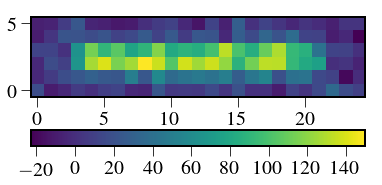

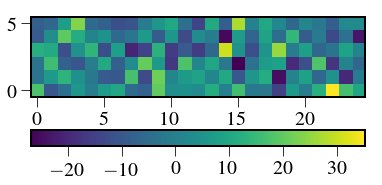

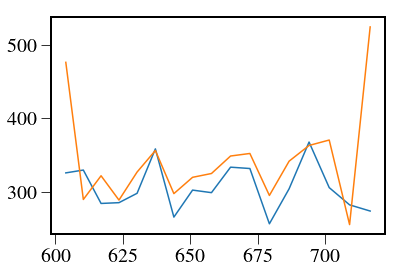

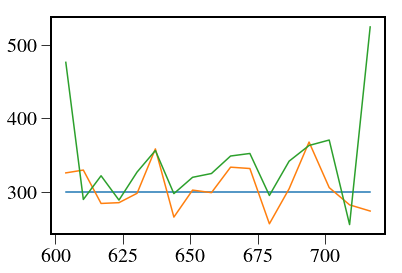

In [35]:

# subim = np.sum(psflet_subarr,axis=0)
# vect = np.array([1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1])
vect = np.ones(psflet_subarr.shape[0])
# vect = np.array([1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0])
subim = np.sum(psflet_subarr*vect[:,np.newaxis,np.newaxis],axis=0)
Nelec = 300
calcSNRtotal(Nelec=Nelec,
        subim=subim,
        psflet_subarr=psflet_subarr,
        pixnoise=100,
        npix=4.5,
        plot=True,
        Niter=1000,
        indspec=8,
        vect = Nelec*vect)

# Study of the RL algorithm with prior

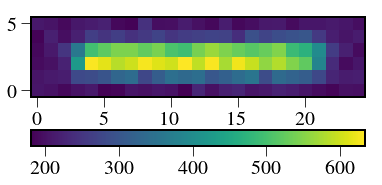

In [64]:
pixnoise = 200
vect = np.ones(psflet_subarr.shape[0])
# vect = np.array([1,2,1,2,1,2,1,2,1,2,1,2,2,1,2,2,1])
subim = np.sum(psflet_subarr*vect[:,np.newaxis,np.newaxis],axis=0)
Nelec = 1000

img = np.random.poisson(subim*Nelec+pixnoise)
plt.imshow(img)
plt.colorbar(orientation='horizontal')

In [65]:
from crispy.tools.reduction import RL,calculateWaveList
val,vallist,loglist,count = RL(img,psflets=psflet_subarr,prior=pixnoise,guess=vect,niter=50)
print vallist.shape

(51, 17)


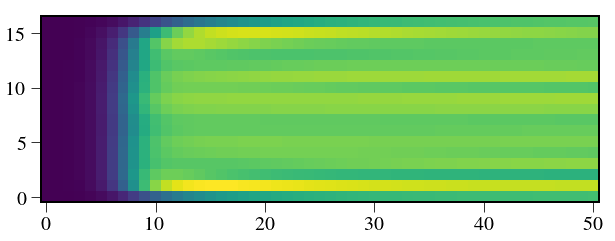

In [66]:
plt.figure(figsize=(10,5))
plt.imshow(vallist.T)

999.740798919


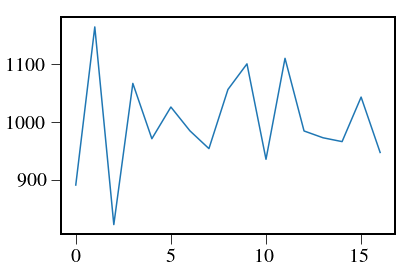

In [67]:
plt.plot(val)
print np.mean(val)

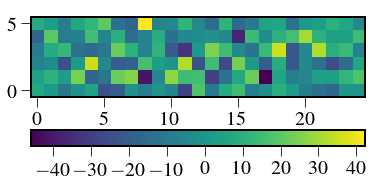

In [68]:
psflets_flat = np.reshape(psflet_subarr, (psflet_subarr.shape[0], -1))
plt.imshow(img-np.reshape(np.dot(psflets_flat.T,val),img.shape)-pixnoise)
plt.colorbar(orientation='horizontal')